1. Import data.

In [17]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length', 'sepal width',
                 'petal length', 'petal width', 'target'])

df.head()


,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


2. Pick features & target.

In [18]:
target = 'target'
features = list(df.columns)
features.remove(target)

print(f">> Target: '{target}'")
print(f'>> Features: {features}')


>> Target: 'target'
>> Features: ['sepal length', 'sepal width', 'petal length', 'petal width']


3. Standardize the data.

In [19]:
from sklearn.preprocessing import StandardScaler

x = df.loc[:, features].values
y = df.loc[:, target].values

x = StandardScaler().fit_transform(x)
features_df = pd.DataFrame(data=x, columns=features)


4. Correlation matrix.

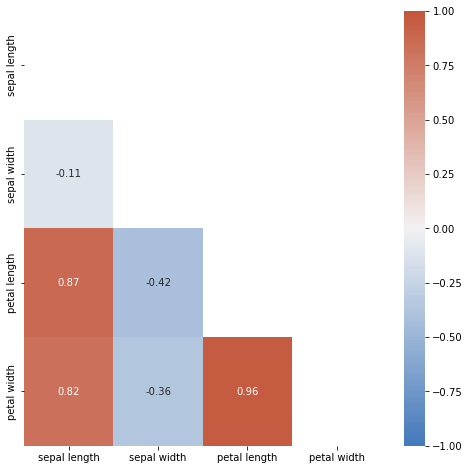

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = features_df.corr().round(2)

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(250, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, 
            vmax=1, vmin=-1, center=0,
            cmap=cmap, mask=mask)
plt.show()


5. PCA.

In [21]:
from sklearn.decomposition import PCA

pca = PCA()

principal_components = pca.fit_transform(x)

labels = [f'PC{x}' for x in range(1, pca.n_components_ + 1)]
principal_df = pd.DataFrame(data=principal_components, columns=labels)
final_df = pd.concat([df[target], principal_df], axis=1)

final_df.head()

,target,PC1,PC2,PC3,PC4
0,Iris-setosa,-2.264542,0.505704,-0.121943,-0.023073
1,Iris-setosa,-2.086426,-0.655405,-0.227251,-0.103208
2,Iris-setosa,-2.367950,-0.318477,0.051480,-0.027825
3,Iris-setosa,-2.304197,-0.575368,0.098860,0.066311
4,Iris-setosa,-2.388777,0.674767,0.021428,0.037397


6. Pick principal components count.

6.1. *via* Kaiser.

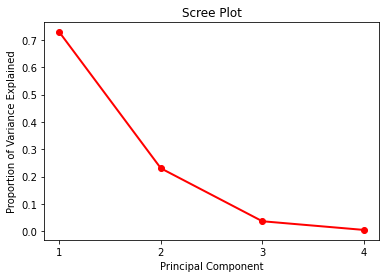

In [22]:
import numpy as np
import matplotlib.pyplot as plt

pc_values = np.arange(pca.n_components_) + 1
plt.plot(pc_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

6.2. *via* The threshold of variance explained approach *(at least 70%)*.

In [23]:
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_ * 100
out_sum = np.cumsum(explained_variance_ratio)

pcs = [f'PC{x}' for x in range(1, pca.n_components_ + 1)]
variance_ratio_df = pd.DataFrame(data={'Proportion of Variance Explained': list(explained_variance_ratio), 'Cumulative Proportion of Variance Explained': list(out_sum)}, 
                           columns=['Proportion of Variance Explained', 'Cumulative Proportion of Variance Explained'],
                           index=pcs)
variance_ratio_df

,Proportion of Variance Explained,Cumulative Proportion of Variance Explained
PC1,72.770452,72.770452
PC2,23.030523,95.800975
PC3,3.683832,99.484807
PC4,0.515193,100.000000


6.3. *via* Hold onto principal components whose eigenvalues are > 1.

In [24]:
variance_ratio_df = pd.DataFrame(data={'Explained Variance': list(pca.explained_variance_)}, 
                                 columns=['Explained Variance'],
                                 index=pcs)
variance_ratio_df

,Explained Variance
PC1,2.930354
PC2,0.927404
PC3,0.148342
PC4,0.020746


7. Interpret final PCA solution.

7.1. Execute PCA with chosen principal components count

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(x)

labels = [f'PC{x}' for x in range(1, pca.n_components_ + 1)]
principal_df = pd.DataFrame(data=principal_components, columns=labels)
final_df = pd.concat([df[target], principal_df], axis=1)

final_df.head()


,target,PC1,PC2
0,Iris-setosa,-2.264542,0.505704
1,Iris-setosa,-2.086426,-0.655405
2,Iris-setosa,-2.367950,-0.318477
3,Iris-setosa,-2.304197,-0.575368
4,Iris-setosa,-2.388777,0.674767


7.2. Loadings.

In [26]:
loadings = pd.DataFrame(pca.components_.T.round(3), columns=labels, index=features)
loadings


,PC1,PC2
sepal length,0.522,0.372
sepal width,-0.263,0.926
petal length,0.581,0.021
petal width,0.566,0.065


In [27]:
# pca general form
for pca_id in range(1, pca.n_components_ + 1):
  print(f'W{pca_id} = ', sep='', end='')
  for feature, row in loadings.iterrows():
    print(f'({row[pca_id - 1]} * {feature})', end=' + ')
  print('\n')

W1 = (0.522 * sepal length) + (-0.263 * sepal width) + (0.581 * petal length) + (0.566 * petal width) + 

W2 = (0.372 * sepal length) + (0.926 * sepal width) + (0.021 * petal length) + (0.065 * petal width) + 



7.3. Loadings Matrix.

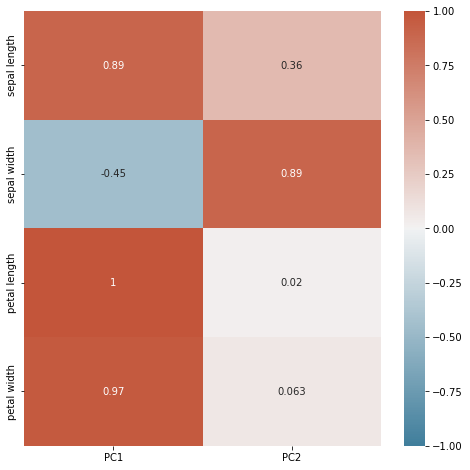

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

loadings_matrix = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=labels, index=features)

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(loadings_matrix, annot=True, 
            vmax=1, vmin=-1, center=0,
            cmap=cmap)
plt.show()


8. PCs visualize 2D Projection

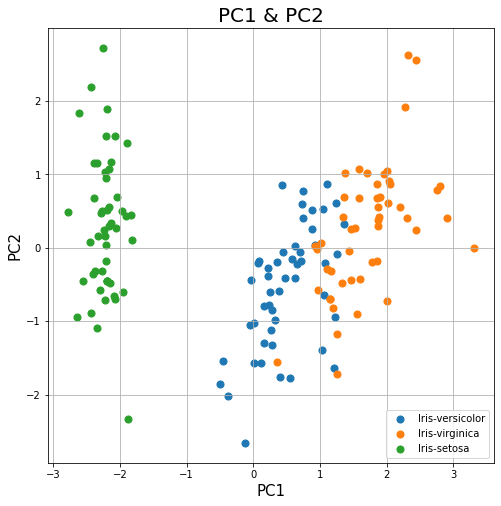

In [44]:
from matplotlib import pyplot as plt


def plot_principal_components(pc_x, pc_y, targets, annot=False, legend=False):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel(pc_x, fontsize=15)
  ax.set_ylabel(pc_y, fontsize=15)
  ax.set_title(f'{pc_x} & {pc_y}', fontsize=20)

  for obs in targets:
    indices_to_keep = df[target] == obs

    x_points = final_df.loc[indices_to_keep, pc_x]
    y_points = final_df.loc[indices_to_keep, pc_y]

    ax.scatter(x_points, y_points, s=50)
    if annot:
      for x, y in zip(x_points, y_points):
        ax.annotate(obs, (x, y))

  if legend:
    ax.legend(targets)
  ax.grid()
  plt.show()

targets = set(df[target])
plot_principal_components('PC1', 'PC2', targets, legend=True)